https://muhark.github.io/python/ml/nlp/2021/10/21/word2vec-from-scratch.html

In [5]:
# !pip install datasets
# !pip install nltk

In [1]:
import torch
import datasets

In [2]:
dataset1 = datasets.load_dataset("tweets_hate_speech_detection")

In [3]:
dataset1

DatasetDict({
    train: Dataset({
        features: ['label', 'tweet'],
        num_rows: 31962
    })
    test: Dataset({
        features: ['label', 'tweet'],
        num_rows: 17197
    })
})

In [4]:
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [5]:
import nltk

In [6]:
sw = nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/indianlyc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
ss = SnowballStemmer('english')
sw = stopwords.words('english')


def split_tokens(row):                             # STEP
    row['all_tokens'] = [ss.stem(i) for i in       # 5
                     re.split(r" +",               # 3
                     re.sub(r"[^a-z@# ]", "",      # 2
                            row['tweet'].lower())) # 1
                     if (i not in sw) and len(i)]  # 4
    return row

dataset2 = dataset1.map(split_tokens)

In [8]:
dataset2["train"]["all_tokens"][0]

['@user', 'father', 'dysfunct', 'selfish', 'drag', 'kid', 'dysfunct', '#run']

In [9]:
dataset2["train"]["tweet"][0]

'@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

In [11]:
from collections import Counter

counts = Counter([i for s in dataset2['train']['all_tokens'] for i in s])
counts = {k:v for k, v in counts.items() if v>10} # Filtering
vocab = list(counts.keys())
n_v = len(vocab)
id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}

# Now correct tokens
def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row

dataset3 = dataset2.map(remove_rare_tokens)

In [34]:
len(tok2id)

3085

In [12]:
dataset3["train"]["tokens"][0]

['@user', 'father', 'drag', 'kid', '#run']

In [13]:
dataset3["train"]["all_tokens"][0]

['@user', 'father', 'dysfunct', 'selfish', 'drag', 'kid', 'dysfunct', '#run']

In [14]:
def windowizer(row, wsize=3):
    """
    Windowizer function for Word2Vec. Converts sentence to sliding-window
    pairs.
    """
    doc = row['tokens']
    wsize = 3
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]
        window = [i+j for j in
                  range(-wsize, wsize+1, 1)
                  if (i+j>=0) &
                     (i+j<len(doc)) &
                     (j!=0)]

        out+=[(target, tok2id[doc[w]]) for w in window]
    row['moving_window'] = out
    return row

dataset4 = dataset3.map(windowizer)

In [15]:
dataset4["train"]["moving_window"][0]

[[0, 1],
 [0, 2],
 [0, 3],
 [1, 0],
 [1, 2],
 [1, 3],
 [1, 4],
 [2, 0],
 [2, 1],
 [2, 3],
 [2, 4],
 [3, 0],
 [3, 1],
 [3, 2],
 [3, 4],
 [4, 1],
 [4, 2],
 [4, 3]]

In [16]:
from torch.utils.data import Dataset, DataLoader

class Word2VecDataset(Dataset):
    """
    Takes a HuggingFace dataset as an input, to be used for a Word2Vec dataloader.
    """
    def __init__(self, dataset, vocab_size, wsize=3):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset['moving_window'] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [17]:
dataset4.keys()

dict_keys(['train', 'test'])

In [18]:
BATCH_SIZE = 2**14
N_LOADER_PROCS = 10

dataloader = {}
for key in dataset4.keys():
    dataloader[key] = DataLoader(Word2VecDataset(
                                    dataset4[key], vocab_size=n_v),
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=N_LOADER_PROCS)


In [19]:
dataloader.keys()

dict_keys(['train', 'test'])

In [20]:
from torch import nn

In [19]:
# from torch import nn

# size = 10
# input_ = 3

# def one_hot_encode(input_, size):
#     vec = torch.zeros(size).float()
#     vec[input_] = 1.0
#     return vec

# ohe = one_hot_encode(input_, size)
# linear_layer = nn.Linear(size, 1, bias=False)

# # Set edge weights from 0 to 9 for easy reference
# with torch.no_grad():
#     linear_layer.weight = nn.Parameter(
#         torch.arange(10, dtype=torch.float).reshape(linear_layer.weight.shape))

# print(linear_layer.weight)
# print(linear_layer(ohe))

In [ ]:
# embedding_layer = nn.Embedding(size, 1)

# with torch.no_grad():
#     embedding_layer.weight = nn.Parameter(
#         torch.arange(10, dtype=torch.float
#         ).reshape(embedding_layer.weight.shape))

# print(embedding_layer.weight)
# print(embedding_layer(torch.tensor(input)))

In [21]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input_):
        # Encode input to lower-dimensional representation
        hidden = self.embed(input_)
        # Expand hidden layer to predictions
        logits = self.expand(hidden)
        return logits

In [22]:
# Instantiate the model
EMBED_SIZE = 100 # Quite small, just for the tutorial
model = Word2Vec(n_v, EMBED_SIZE)

# Relevant if you have a GPU:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define training parameters
LR = 3e-4
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [24]:
from tqdm import tqdm  # For progress bars

progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
running_loss = []
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = model(input_=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)


  0%|                                                                                                                                                                               | 0/530 [02:17<?, ?it/s]

 42%|█████████████████████████████████████████████████████████████████████▍                                                                                               | 223/530 [00:08<00:09, 32.07it/s]


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 460/530 [00:14<00:01, 43.94it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:32<00:00, 51.32it/s]

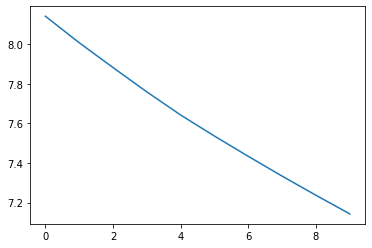

In [25]:
import matplotlib.pyplot as plt
plt.plot(running_loss)

In [26]:
wordvecs = model.expand.weight.cpu().detach().numpy()
tokens = ['good', 'father', 'school', 'hate']

In [27]:
from scipy.spatial import distance
import numpy as np

def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix

def get_k_similar_words(word, dist_matrix, k=10):
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k+1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out

dmat = get_distance_matrix(wordvecs, 'cosine')
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

good ['year', 'anoth', 'last', 'sta', 'hope', 'way', 'follow', 'everi', 'watch', 'today'] 

father ['dad', 'day', 'happi', '#fathersday', 'dont', 'everi', 'beauti', 'make', 'hope', 'cant'] 

school ['great', 'today', 'look', 'get', 'one', 'day', 'tomorrow', 'show', 'work', 'let'] 

hate ['peopl', 'mani', '@user', 'im', 'much', 'dont', 'sta', 'white', 'world', 'hea'] 



In [29]:
EPOCHS = 90
progress_bar = tqdm(range(EPOCHS * len(dataloader['train'])))
for epoch in range(EPOCHS):
    epoch_loss = 0
    for center, context in dataloader['train']:
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = model(input_=context)
        loss = loss_fn(logits, center)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar.update(1)
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)


  0%|                                                                                                                                                                              | 0/4770 [00:07<?, ?it/s]

  5%|███████▊                                                                                                                                                            | 226/4770 [00:06<02:28, 30.66it/s]


 10%|███████████████▉                                                                                                                                                    | 462/4770 [00:12<01:36, 44.52it/s]


 15%|████████████████████████▏                                                                                                                                           | 702/4770 [00:19<02:01, 33.37it/s]


 20%|████████████████████████████████▎                                                                                                                                   | 939/4770 [00:25<01:24, 45.10it/s]


 25%|████████████████████████████████████████▎                                                                                                                          | 1178/4770 [00:32<01:51, 32.32it/s]


 30%|████████████████████████████████████████████████▍                                                                                                                  | 1419/4770 [00:38<01:11, 47.17it/s]


 35%|████████████████████████████████████████████████████████▋                                                                                                          | 1660/4770 [00:45<01:23, 37.33it/s]


 40%|████████████████████████████████████████████████████████████████▉                                                                                                  | 1900/4770 [00:51<00:58, 49.34it/s]


 45%|█████████████████████████████████████████████████████████████████████████                                                                                          | 2139/4770 [00:58<01:08, 38.53it/s]


 50%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                 | 2381/4770 [01:04<00:45, 52.18it/s]


 55%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 2615/4770 [01:11<01:01, 34.98it/s]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2851/4770 [01:17<00:39, 48.35it/s]


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 3091/4770 [01:24<00:50, 33.54it/s]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 3333/4770 [01:30<00:28, 50.73it/s]


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 3572/4770 [01:37<00:31, 38.59it/s]


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 3817/4770 [01:44<00:39, 24.36it/s]


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 4048/4770 [01:50<00:19, 37.35it/s]


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 4284/4770 [01:57<00:10, 47.85it/s]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 4518/4770 [02:04<00:07, 32.23it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 4754/4770 [02:10<00:00, 45.39it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 4767/4770 [02:10<00:00, 51.12it/s]

In [32]:
wordvecs_100_epochs = model.expand.weight.cpu().detach().numpy()
dmat_100_epochs = get_distance_matrix(wordvecs_100_epochs, 'cosine')
for word in tokens:
    print(word, [t for t in get_k_similar_words(word, dmat_100_epochs)], "\n")

good [(137, 'great', 0.20833959802579738), (578, 'everyon', 0.2197420906167269), (389, 'hope', 0.22526707064736995), (111, 'day', 0.22786498855112736), (64, 'today', 0.22813740149598838), (418, 'friend', 0.22911838681096075), (0, '@user', 0.2325512774096805), (187, 'morn', 0.24707507998632172), (188, 'one', 0.24736691575519343), (345, 'go', 0.24794624600810977)] 

father [(799, 'dad', 0.13724676669714753), (821, '#fathersday', 0.2312980559650395), (111, 'day', 0.2418103365692682), (822, 'wish', 0.28093457919913045), (112, 'happi', 0.28758843910042786), (14, 'love', 0.30236388911332357), (798, 'wonder', 0.3081727839458056), (757, 'world', 0.3223546668793964), (378, 'us', 0.33502965680230656), (389, 'hope', 0.3352010339240056)] 

school [(33, 'year', 0.32645289598564575), (590, 'meet', 0.3498776993646332), (344, 'week', 0.365671808239988), (111, 'day', 0.36626775747857554), (231, 'first', 0.37144252437102665), (371, 'back', 0.37788622081285494), (30, 'tomorrow', 0.3927732447651018), (814

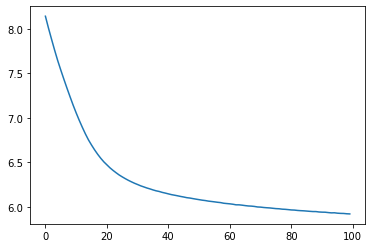


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4770/4770 [02:23<00:00, 51.12it/s]

In [31]:
import matplotlib.pyplot as plt
plt.plot(running_loss)